## Top User Sentiments

*Prepared by:*  
**Jude Michael Teves**  
Data Scientist / Machine Learning Engineer, Asian Development Bank

## Preliminaries

Note that this notebook is dependent on the CSV files generated by `top-user-tweets-parser.ipynb`.

### Import Packages

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

import glob, re, json

from itertools import chain
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer, SentiText

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jude_\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Vader Constants / Extra Lexemes

The following can be found here: https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vaderSentiment.py

In [49]:
B_INCR = 0.293
B_DECR = -0.293

# (empirically derived mean sentiment intensity rating increase for using
# ALLCAPs to emphasize a word)
C_INCR = 0.733

N_SCALAR = -0.74
    
NEGATE = \
    ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt",
     "ain't", "aren't", "can't", "couldn't", "daren't", "didn't", "doesn't",
     "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", "neither",
     "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
     "neednt", "needn't", "never", "none", "nope", "nor", "not", "nothing", "nowhere",
     "oughtnt", "shant", "shouldnt", "uhuh", "wasnt", "werent",
     "oughtn't", "shan't", "shouldn't", "uh-uh", "wasn't", "weren't",
     "without", "wont", "wouldnt", "won't", "wouldn't", "rarely", "seldom", "despite"]

# booster/dampener 'intensifiers' or 'degree adverbs'
# http://en.wiktionary.org/wiki/Category:English_degree_adverbs

BOOSTER_DICT = \
    {"absolutely": B_INCR, "amazingly": B_INCR, "awfully": B_INCR, 
     "completely": B_INCR, "considerable": B_INCR, "considerably": B_INCR,
     "decidedly": B_INCR, "deeply": B_INCR, "effing": B_INCR, "enormous": B_INCR, "enormously": B_INCR,
     "entirely": B_INCR, "especially": B_INCR, "exceptional": B_INCR, "exceptionally": B_INCR, 
     "extreme": B_INCR, "extremely": B_INCR,
     "fabulously": B_INCR, "flipping": B_INCR, "flippin": B_INCR, "frackin": B_INCR, "fracking": B_INCR,
     "fricking": B_INCR, "frickin": B_INCR, "frigging": B_INCR, "friggin": B_INCR, "fully": B_INCR, 
     "fuckin": B_INCR, "fucking": B_INCR, "fuggin": B_INCR, "fugging": B_INCR,
     "greatly": B_INCR, "hella": B_INCR, "highly": B_INCR, "hugely": B_INCR, 
     "incredible": B_INCR, "incredibly": B_INCR, "intensely": B_INCR, 
     "major": B_INCR, "majorly": B_INCR, "more": B_INCR, "most": B_INCR, "particularly": B_INCR,
     "purely": B_INCR, "quite": B_INCR, "really": B_INCR, "remarkably": B_INCR,
     "so": B_INCR, "substantially": B_INCR,
     "thoroughly": B_INCR, "total": B_INCR, "totally": B_INCR, "tremendous": B_INCR, "tremendously": B_INCR,
     "uber": B_INCR, "unbelievably": B_INCR, "unusually": B_INCR, "utter": B_INCR, "utterly": B_INCR,
     "very": B_INCR,
     "almost": B_DECR, "barely": B_DECR, "hardly": B_DECR, "just enough": B_DECR,
     "kind of": B_DECR, "kinda": B_DECR, "kindof": B_DECR, "kind-of": B_DECR,
     "less": B_DECR, "little": B_DECR, "marginal": B_DECR, "marginally": B_DECR,
     "occasional": B_DECR, "occasionally": B_DECR, "partly": B_DECR,
     "scarce": B_DECR, "scarcely": B_DECR, "slight": B_DECR, "slightly": B_DECR, "somewhat": B_DECR,
     "sort of": B_DECR, "sorta": B_DECR, "sortof": B_DECR, "sort-of": B_DECR}

# check for sentiment laden idioms that do not contain lexicon words (future work, not yet implemented)
SENTIMENT_LADEN_IDIOMS = {"cut the mustard": 2, "hand to mouth": -2,
                          "back handed": -2, "blow smoke": -2, "blowing smoke": -2,
                          "upper hand": 1, "break a leg": 2,
                          "cooking with gas": 2, "in the black": 2, "in the red": -2,
                          "on the ball": 2, "under the weather": -2}

# check for special case idioms and phrases containing lexicon words
SPECIAL_CASES = {"the shit": 3, "the bomb": 3, "bad ass": 1.5, "badass": 1.5, "bus stop": 0.0,
                 "yeah right": -2, "kiss of death": -1.5, "to die for": 3, 
                 "beating heart": 3.1, "broken heart": -2.9 }

## Check Sentiments

We check if the lowercase version of a token exists in our augmented lexicon

In [62]:
lexicon_augmented = list(chain(*[sid.lexicon, NEGATE, BOOSTER_DICT, SENTIMENT_LADEN_IDIOMS, SPECIAL_CASES]))

def get_used_tokens_ratio(text:str) -> float:
    sentitext = SentiText(text)
    tokens = sentitext.words_and_emoticons    
    if len(tokens)==0:
        return 0
    tokens_in_lexicon_mask =  [token.lower() in lexicon_augmented for token in tokens]
    return sum(tokens_in_lexicon_mask)/len(tokens_in_lexicon_mask)

In [71]:
def read_csv_and_calculate_sentiment_and_token_ratio(filename:str) -> pd.DataFrame:
    df = pd.read_csv(filename)
    df = df[['text']]

    sid = SentimentIntensityAnalyzer()
    df['sentiment_score'] = df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    df['used_tokens'] = df['text'].apply(get_used_tokens_ratio)
    
    return df

In [75]:
def display_statistics_and_graphs(df:pd.DataFrame):
    display(df.describe().T)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), dpi=100)
    sns.distplot(df['sentiment_score'], ax=ax1)
    ax1.set_title('Sentiment Score Distribution')

    sns.distplot(df['used_tokens'], ax=ax2)
    ax2.set_title('Used Tokens Ratio Distribution')

    plt.tight_layout()
    plt.show()

### March 2019

In [76]:
filename = 'top_tweets_2019_03.csv'
df_2019 = read_csv_and_calculate_sentiment_and_token_ratio(filename)
df_2019.head()

,text,sentiment_score,used_tokens
0,India in space:-\n1962: INCOSPAR by Jawaharlal...,0.0000,0.000000
1,RT @NewsHtn: Exclusive interview with #Raghura...,0.1280,0.100000
2,A salesman at our door! After selling us jumla...,0.0000,0.000000
3,RT @dhruv_rathee: Read the truth behind how Mo...,0.7184,0.086957
4,#Dubai Burj Khalifa sends peace &amp; respect ...,-0.2960,0.200000


,count,mean,std,min,25%,50%,75%,max
sentiment_score,4338.0,0.162327,0.406923,-0.9539,0.0,0.000000,0.493900,0.9742
used_tokens,4338.0,0.102434,0.106772,0.0000,0.0,0.083333,0.153846,0.7500


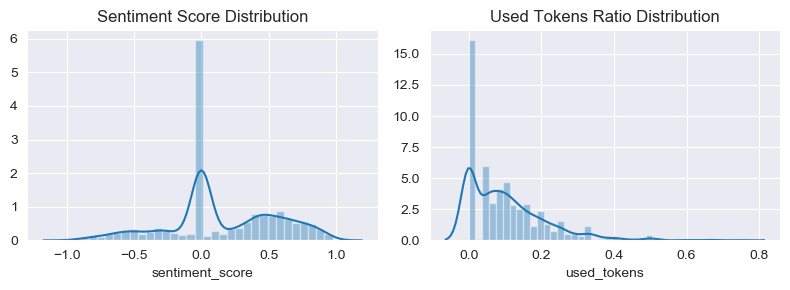

In [77]:
display_statistics_and_graphs(df_2019)

#### Save VADER results

In [80]:
df_2019.to_csv('vader_sentiments_2019_03.csv', index=False)

### March 2020

In [78]:
filename = 'top_tweets_2020_03.csv'
df_2020 = read_csv_and_calculate_sentiment_and_token_ratio(filename)
df_2020.head()

,text,sentiment_score,used_tokens
0,RT @SINGHSAKSHI15: Dear @DrSJaishankar and @PM...,0.3818,0.047619
1,RT @Drsunil0198: All international indian stud...,0.4995,0.076923
2,The 538 new cases and 10 Deaths reported today...,0.3182,0.090909
3,This is to inform you that students are studyi...,-0.6249,0.047619
4,RT @Sandra68043039: Indian Students stuck in U...,-0.5413,0.176471


,count,mean,std,min,25%,50%,75%,max
sentiment_score,15284.0,0.090994,0.412610,-0.9623,0.0,0.000000,0.427800,0.9805
used_tokens,15284.0,0.098824,0.104329,0.0000,0.0,0.083333,0.142857,1.0000


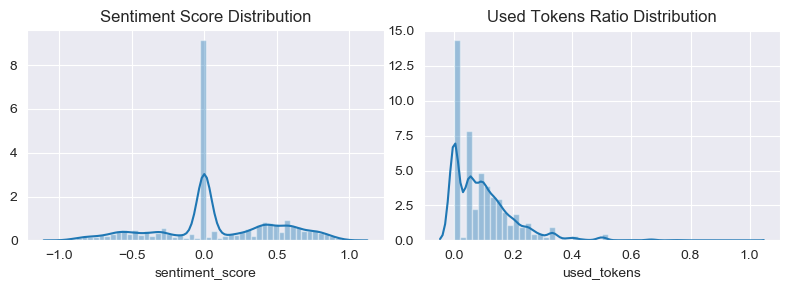

In [79]:
display_statistics_and_graphs(df_2020)

#### Save VADER results

In [81]:
df_2020.to_csv('vader_sentiments_2020_03.csv', index=False)